<a href="https://colab.research.google.com/github/DoSungjin/Dacon_papering_classification/blob/master/SinGAN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SinGAN

[Official SinGAN Repository](https://github.com/tamarott/SinGAN)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#requires older version of PyTorch.
!pip3 install torch==2.0.0
!pip install torchvision==0.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.0 r

In [19]:
%cd /content/
!git clone https://github.com/tamarott/SinGAN.git

%cd /content/drive/MyDrive/SinGAN
!git checkout experimental

%cd /content/drive/MyDrive/SinGAN/Input/Images/
!ls

/content
Cloning into 'SinGAN'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 811 (delta 1), reused 3 (delta 1), pack-reused 806
Receiving objects: 100% (811/811), 94.89 MiB | 35.82 MiB/s, done.
Resolving deltas: 100% (315/315), done.
/content/drive/MyDrive/SinGAN
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/content/drive/MyDrive/SinGAN/Input/Images
0.png  1.png  2.png  tree_resized.png


original image
(697, 618, 3)


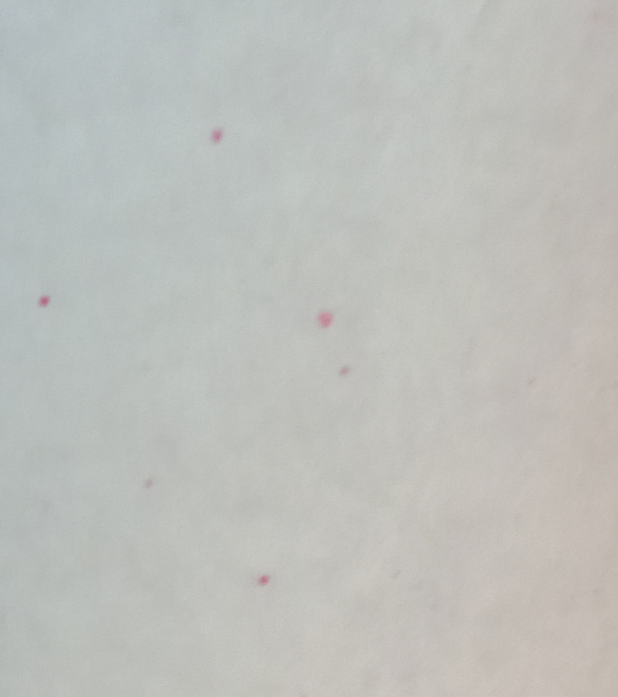

original image
(697, 618, 3)


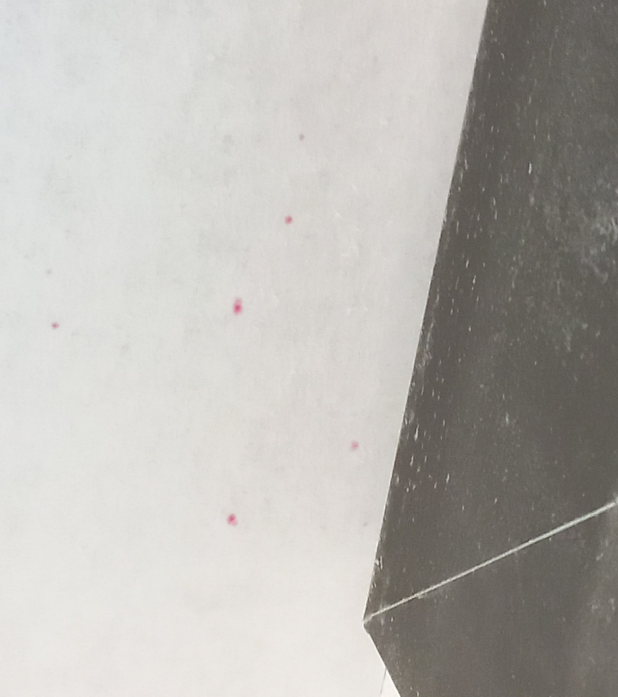

drive  sample_data


In [5]:
import cv2
import glob
from google.colab.patches import cv2_imshow

print('original image')
original_img_path = '/content/drive/MyDrive/SinGAN/Input/Images/0.png'
img = cv2.imread(original_img_path)
print(img.shape)
cv2_imshow(img)

print('original image')
original_img_path = '/content/drive/MyDrive/SinGAN/Input/Images/1.png'
img2 = cv2.imread(original_img_path)
new_img = cv2.resize(img2, (img.shape[1], img.shape[0]))
print(new_img.shape)
cv2_imshow(new_img)
cv2.imwrite('/content/drive/MyDrive/SinGAN/Input/Images/tree_resized.png', new_img)
!ls

# Let's train SinGAN here

In [6]:
#training.py
def train_single_scale2(netD,netG,reals,Gs,Zs,in_s,NoiseAmp,opt,centers=None):
    print('placeholder')
    real = reals[len(Gs)]
    opt.nzx = real.shape[2]#+(opt.ker_size-1)*(opt.num_layer)
    opt.nzy = real.shape[3]#+(opt.ker_size-1)*(opt.num_layer)
    opt.receptive_field = opt.ker_size + ((opt.ker_size-1)*(opt.num_layer-1))*opt.stride
    pad_noise = int(((opt.ker_size - 1) * opt.num_layer) / 2)
    pad_image = int(((opt.ker_size - 1) * opt.num_layer) / 2)
    if opt.mode == 'animation_train':
        opt.nzx = real.shape[2]+(opt.ker_size-1)*(opt.num_layer)
        opt.nzy = real.shape[3]+(opt.ker_size-1)*(opt.num_layer)
        pad_noise = 0
    m_noise = nn.ZeroPad2d(int(pad_noise))
    m_image = nn.ZeroPad2d(int(pad_image))

    alpha = opt.alpha

    fixed_noise = functions.generate_noise([opt.nc_z,opt.nzx,opt.nzy],device=opt.device)
    z_opt = torch.full(fixed_noise.shape, 0, device=opt.device)
    z_opt = m_noise(z_opt)

    # setup optimizer
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999))
    schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerD,milestones=[1600],gamma=opt.gamma)
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerG,milestones=[1600],gamma=opt.gamma)

    errD2plot = []
    errG2plot = []
    D_real2plot = []
    D_fake2plot = []
    z_opt2plot = []


 
    #for epoch in range(int(opt.niter / 2)):
    for epoch in range(5):
        if (Gs == []) & (opt.mode != 'SR_train'):
            z_opt = functions.generate_noise([1,opt.nzx,opt.nzy], device=opt.device)
            z_opt = m_noise(z_opt.expand(1,3,opt.nzx,opt.nzy))
            noise_ = functions.generate_noise([1,opt.nzx,opt.nzy], device=opt.device)
            noise_ = m_noise(noise_.expand(1,3,opt.nzx,opt.nzy))
        else:
            noise_ = functions.generate_noise([opt.nc_z,opt.nzx,opt.nzy], device=opt.device)
            noise_ = m_noise(noise_)

        # (1) Update D network:

        for j in range(int(opt.Dsteps)):
            # train with real
            netD.zero_grad()

            output = netD(real).to(opt.device)
            #D_real_map = output.detach()
            errD_real = -output.mean()#-a
            errD_real.backward(retain_graph=True)
            D_x = -errD_real.item()

            # train with fake
            if (j==0) & (epoch == 0):
                if (Gs == []) & (opt.mode != 'SR_train'):
                    prev = torch.full([1,opt.nc_z,opt.nzx,opt.nzy], 0, device=opt.device)
                    in_s = prev
                    prev = m_image(prev)
                    z_prev = torch.full([1,opt.nc_z,opt.nzx,opt.nzy], 0, device=opt.device)
                    z_prev = m_noise(z_prev)
                    opt.noise_amp = 1
                elif opt.mode == 'SR_train':
                    z_prev = in_s
                    criterion = nn.MSELoss()
                    RMSE = torch.sqrt(criterion(real, z_prev))
                    opt.noise_amp = opt.noise_amp_init * RMSE
                    z_prev = m_image(z_prev)
                    prev = z_prev
                else:
                    prev = draw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rand',m_noise,m_image,opt)
                    prev = m_image(prev)
                    z_prev = draw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rec',m_noise,m_image,opt)
                    criterion = nn.MSELoss()
                    RMSE = torch.sqrt(criterion(real, z_prev))
                    opt.noise_amp = opt.noise_amp_init*RMSE
                    z_prev = m_image(z_prev)
            else:
                prev = draw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rand',m_noise,m_image,opt)
                prev = m_image(prev)

            if opt.mode == 'paint_train':
                prev = functions.quant2centers(prev,centers)
                plt.imsave('%s/prev.png' % (opt.outf), functions.convert_image_np(prev), vmin=0, vmax=1)

            if (Gs == []) & (opt.mode != 'SR_train'):
                noise = noise_
            else:
                noise = opt.noise_amp*noise_+prev

            fake = netG(noise.detach(),prev)
            output = netD(fake.detach())
            # NOTE: netD outputs a tensor. The Discriminator is fully convolution and does not depend on the size of the image.
            # An image is real or fake depending on the mean of the output tensor.
            # Maybe we can talk about this in our Blog post?
            errD_fake = output.mean()
            errD_fake.backward(retain_graph=True)
            D_G_z = output.mean().item()

            gradient_penalty = functions.calc_gradient_penalty(netD, real, fake, opt.lambda_grad, opt.device)
            gradient_penalty.backward()

            errD = errD_real + errD_fake + gradient_penalty
            optimizerD.step()

        errD2plot.append(errD.detach())

  
        # (2) Update G network: 

        for j in range(opt.Gsteps):
            netG.zero_grad()
            output = netD(fake)
            #D_fake_map = output.detach()
            errG = -output.mean()
            errG.backward(retain_graph=True)
            if alpha!=0:
                loss = nn.MSELoss()
                if opt.mode == 'paint_train':
                    z_prev = functions.quant2centers(z_prev, centers)
                    plt.imsave('%s/z_prev.png' % (opt.outf), functions.convert_image_np(z_prev), vmin=0, vmax=1)
                Z_opt = opt.noise_amp*z_opt+z_prev
                rec_loss = alpha*loss(netG(Z_opt.detach(),z_prev),real)
                rec_loss.backward(retain_graph=True)
                rec_loss = rec_loss.detach()
            else:
                Z_opt = z_opt
                rec_loss = 0

            optimizerG.step()

        errG2plot.append(errG.detach()+rec_loss)
        D_real2plot.append(D_x)
        D_fake2plot.append(D_G_z)
        z_opt2plot.append(rec_loss)

        if epoch % 25 == 0 or epoch == (opt.niter-1):
            print('scale %d:[%d/%d]' % (len(Gs), epoch, opt.niter))

        if epoch % 500 == 0 or epoch == (opt.niter-1):
            plt.imsave('%s/fake_sample.png' %  (opt.outf), functions.convert_image_np(fake.detach()), vmin=0, vmax=1)
            plt.imsave('%s/G(z_opt).png'    % (opt.outf),  functions.convert_image_np(netG(Z_opt.detach(), z_prev).detach()), vmin=0, vmax=1)
            #plt.imsave('%s/D_fake.png'   % (opt.outf), functions.convert_image_np(D_fake_map))
            #plt.imsave('%s/D_real.png'   % (opt.outf), functions.convert_image_np(D_real_map))
            #plt.imsave('%s/z_opt.png'    % (opt.outf), functions.convert_image_np(z_opt.detach()), vmin=0, vmax=1)
            #plt.imsave('%s/prev.png'     %  (opt.outf), functions.convert_image_np(prev), vmin=0, vmax=1)
            #plt.imsave('%s/noise.png'    %  (opt.outf), functions.convert_image_np(noise), vmin=0, vmax=1)
            #plt.imsave('%s/z_prev.png'   % (opt.outf), functions.convert_image_np(z_prev), vmin=0, vmax=1)


            torch.save(z_opt, '%s/z_opt.pth' % (opt.outf))

        schedulerD.step()
        schedulerG.step()

    functions.save_networks(netG,netD,z_opt,opt)
    return z_opt,in_s,netG    

In [7]:
#models.py

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class ConvBlock(nn.Sequential):
  def __init__(self, in_channel, out_channel, ker_size, padd, stride):
    super(ConvBlock, self).__init__()
    self.add_module('conv', nn.Conv2d(in_channel, out_channel, kernel_size=ker_size, stride=stride, padding=padd)),
    self.add_module('norm', nn.BatchNorm2d(out_channel)),
    self.add_module('LeakyRelu', nn.LeakyReLU(0.2))

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv2d') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('Norm') != -1:
    m.weight.data.normal_(1.0, 0.01)
    m.bias.data.fill_(0)

class WDiscriminator2(nn.Module):
    def __init__(self, opt):
        super(WDiscriminator2, self).__init__()
        self.is_cuda = torch.cuda.is_available()
        N = int(opt.nfc)
        self.head = ConvBlock(opt.nc_im,N,opt.ker_size,opt.padd_size,1)
        self.body = nn.Sequential()
        for i in range(opt.num_layer-2):
            N = int(opt.nfc/pow(2,(i+1)))
            block = ConvBlock(max(2*N,opt.min_nfc),max(N,opt.min_nfc),opt.ker_size,opt.padd_size,1)
            self.body.add_module('block%d'%(i+1),block)
        self.tail = nn.Conv2d(max(N,opt.min_nfc),1,kernel_size=opt.ker_size,stride=1,padding=opt.padd_size)

    def forward(self,x):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        return x

class GeneratorConcatSkip2CleanAdd2(nn.Module):
    def __init__(self, opt):
        super(GeneratorConcatSkip2CleanAdd2, self).__init__()
        self.is_cuda = torch.cuda.is_available()
        N = opt.nfc
        self.head = ConvBlock(opt.nc_im,N,opt.ker_size,opt.padd_size,1) #GenConvTransBlock(opt.nc_z,N,opt.ker_size,opt.padd_size,opt.stride)
        self.body = nn.Sequential()
        for i in range(opt.num_layer-2):
            N = int(opt.nfc/pow(2,(i+1)))
            block = ConvBlock(max(2*N,opt.min_nfc),max(N,opt.min_nfc),opt.ker_size,opt.padd_size,1)
            self.body.add_module('block%d'%(i+1),block)
        self.tail = nn.Sequential(
            nn.Conv2d(max(N,opt.min_nfc),opt.nc_im,kernel_size=opt.ker_size,stride =1,padding=opt.padd_size),
            nn.Tanh()
        )
    def forward(self,x,y):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        ind = int((y.shape[2]-x.shape[2])/2)
        y = y[:,:,ind:(y.shape[2]-ind),ind:(y.shape[3]-ind)]
        return x+y

class DummyOpt:
  def __init__(self):
    self.nfc = 32
    self.nc_im = 3
    self.ker_size = 3
    self.padd_size = 1
    self.num_layer = 5
    self.min_nfc = 3
opt_example = DummyOpt()
D_example = WDiscriminator2(opt_example)
G_example = GeneratorConcatSkip2CleanAdd2(opt_example)

print(D_example)
print(G_example)

WDiscriminator2(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2)
    )
    (block2): ConvBlock(
      (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2)
    )
    (block3): ConvBlock(
      (conv): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu):

In [8]:
#functions.py
def read_image2(opt):
    x = img.imread('%s/%s' % (opt.input_dir,opt.input_name))
    x = functions.np2torch(x,opt)
    x = x[:,0:3,:,:]

    x2 = img.imread('%s/%s' % (opt.input_dir,opt.input_name2))
    x2 = functions.np2torch(x2,opt)
    x2 = x2[:,0:3,:,:]

    array = [x, x2]
    return array

def train2(opt,Gs,Zs,reals, reals2,NoiseAmp):
    array = read_image2(opt)
    real_ = array[0]
    real_2 = array[1]
    in_s = 0
    scale_num = 0
    real = imresize(real_,opt.scale1,opt)
    real2 = imresize(real_2,opt.scale1,opt)
    reals = functions.creat_reals_pyramid(real,reals,opt)
    reals2 = functions.creat_reals_pyramid(real2,reals2,opt)
    nfc_prev = 0

    while scale_num<opt.stop_scale+1:
        opt.nfc = min(opt.nfc_init * pow(2, math.floor(scale_num / 4)), 128)
        opt.min_nfc = min(opt.min_nfc_init * pow(2, math.floor(scale_num / 4)), 128)

        opt.out_ = functions.generate_dir2save(opt)
        opt.outf = '%s/%d' % (opt.out_,scale_num)
        try:
            os.makedirs(opt.outf)
        except OSError:
                pass

        #plt.imsave('%s/in.png' %  (opt.out_), functions.convert_image_np(real), vmin=0, vmax=1)
        #plt.imsave('%s/original.png' %  (opt.out_), functions.convert_image_np(real_), vmin=0, vmax=1)
        plt.imsave('%s/real_scale.png' %  (opt.outf), functions.convert_image_np(reals[scale_num]), vmin=0, vmax=1)

        D_curr,G_curr = init_models(opt)
        if (nfc_prev==opt.nfc):
            G_curr.load_state_dict(torch.load('%s/%d/netG.pth' % (opt.out_,scale_num-1)))
            D_curr.load_state_dict(torch.load('%s/%d/netD.pth' % (opt.out_,scale_num-1)))

        for j in range(100):
            z_curr,in_s,G_curr = train_single_scale2(D_curr,G_curr,reals,Gs,Zs,in_s,NoiseAmp,opt)
            z_curr,in_s,G_curr = train_single_scale2(D_curr,G_curr,reals2,Gs,Zs,in_s,NoiseAmp,opt)
        

        G_curr = functions.reset_grads(G_curr,False)
        G_curr.eval()
        D_curr = functions.reset_grads(D_curr,False)
        D_curr.eval()

        Gs.append(G_curr)
        Zs.append(z_curr)
        NoiseAmp.append(opt.noise_amp)

        torch.save(Zs, '%s/Zs.pth' % (opt.out_))
        torch.save(Gs, '%s/Gs.pth' % (opt.out_))
        torch.save(reals, '%s/reals.pth' % (opt.out_))
        torch.save(NoiseAmp, '%s/NoiseAmp.pth' % (opt.out_))

        scale_num+=1
        nfc_prev = opt.nfc
        del D_curr,G_curr
    return

In [9]:
%cd /content/drive/MyDrive/SinGAN

/content/drive/MyDrive/SinGAN


In [10]:
!pip install config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip3 install --upgrade config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
#%cd /content/SinGAN/ 
!git checkout experimental
![ -d TrainedModels ] && rm -r TrainedModels
import torch
import torch.nn as nn
import sys
import os

# Import help functions from SinGAN
import config
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
import SinGAN.functions as functions

print('Implement SinGAN here...')

# Replace the specific functions we want to reimplement
SinGAN.training.train_single_scale = train_single_scale2
SinGAN.training.train = train2
SinGAN.models.WDiscriminator = WDiscriminator2
SinGAN.models.GeneratorConcatSkip2CleanAdd = GeneratorConcatSkip2CleanAdd2
functions.read_image = read_image2

del sys.argv[:]
sys.argv.append('main_train.py')

parser = get_arguments()
parser.add_argument('--input_dir', help='input image dir', default='Input/Images')
parser.add_argument('--input_name', help='input image name', default='LRImage.png')
parser.add_argument('--mode', help='task to be done', default='train')

opt = parser.parse_args()
opt = functions.post_config(opt)

Gs = []
Zs = []
reals = []
reals2 = []
NoiseAmp = []
dir2save = functions.generate_dir2save(opt)

if os.path.exists(dir2save):
  print('trained model already exists: {}'.format(dir2save))
else:
  try:
    os.makedirs(dir2save)
  except OSError:
    pass
  print(opt)
  print(functions.read_image)
  #opt.ref_image = ''
  opt.input_name = 'HRImage.png'
  opt.input_name2 = 'tree_resized.png'
  array = functions.read_image(opt)
  real = array[0]
  real2 = array[1]
  #real = functions.read_image(opt)
  functions.adjust_scales2image(real, opt)
  train2(opt, Gs, Zs, reals, reals2, NoiseAmp)
  SinGAN_generate(Gs,Zs,reals,NoiseAmp,opt)

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


ModuleNotFoundError: ignored

In [ ]:
amkdir /content/SinGAN/Output/RandomSamples/LRImage

# Evaluation


In [ ]:
#SR.py -> arguments input image dir, training image name, super resolution factor
!python3 SR.py --input_name LRImage.png --mode random_samples_arbitrary_sizes --scale_h 1 --scale_v 1
!ls
!ls -l Output/RandomSamples/HRImage
!ls -l Output/RandomSamples/HRImage/gen_start_scale=0

In [ ]:
import cv2
import glob
from google.colab.patches import cv2_imshow

print('original image')
original_img_path = 'Input/Images/LRImage.png'
img = cv2.imread(original_img_path)
cv2_imshow(img)

print('original image')
original_img_path = 'Input/Images/LRImage.png'
img = cv2.imread(original_img_path)
cv2_imshow(img)

# Get generated images
img_paths = glob.glob('Output/RandomSamples/HRImage/gen_start_scale=0/*.png')

print('random sample')
img = cv2.imread(img_paths[0])
cv2_imshow(img)

print('random sample')
img = cv2.imread(img_paths[1])
cv2_imshow(img)

print('random sample')
img = cv2.imread(img_paths[2])
cv2_imshow(img)

print('random sample')
img = cv2.imread(img_paths[3])
cv2_imshow(img)

print('random sample')
img = cv2.imread(img_paths[4])
cv2_imshow(img)

print('random sample')
img = cv2.imread(img_paths[5])
cv2_imshow(img)